<a href="https://colab.research.google.com/github/arnabbiswas66/multimodal-fake-news-classifier/blob/main/Experiments/Weibo_Experiments_text_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiment 1** - (Text-only) BERT, XLM-RoBERTa as text embedding

## BERT

In [1]:
!pip install -q tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.4 MB/s eta 0:00:00


In [2]:
from tensorflow.python.platform.tf_logging import warn
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import re
from os import listdir
import shutil
import glob
import random
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
tf.get_logger().setLevel('ERROR')
import warnings

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the dataframes

In [4]:
BASE_SAVE_LOCATION = "/content/drive/MyDrive/multimodal-news"
CHECKPOINT_FILEPATH = '/content/drive/MyDrive/multimodal-news/weibo/'

In [5]:
#Load training df
train_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/weibo-train.pickle")
#Load testing df
test_df_model = pd.read_pickle(BASE_SAVE_LOCATION+"/weibo-test.pickle")
print(train_df_model.shape, test_df_model.shape)

(4140, 3) (1124, 3)


# Data input pipeline

In [6]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/bert_zh_L-12_H-768_A-12/4"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_zh_preprocess/3"

In [7]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [8]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"], 224)
bert_preprocess_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None, None)        0         
                                                                 
 packer (KerasLayer)         {'input_type_ids': (None  0         
                             , 224),                             
                              'input_word_ids': (None            
                             , 224),                             
                              'input_mask': (None, 22            
                             4)}                                 
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [9]:
idx = np.random.choice(len(train_df_model))
row = train_df_model.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: 【女大学生网恋残疾小伙三日定情 对方酷似周杰伦】90后女大学生小丹在网上认识了广州一男孩，两人不到三天坠入爱河。当她只身前往广州后，发现男孩竟是双腿失去行动能力，而小丹却做出惊人决定：退学向对方求婚，并承诺照顾对方一生。男孩长得像周杰伦，弹得一手好吉他。（姑娘，你愿意吗？）
Text 2: 【女大学生网恋残疾小伙三日定情 对方酷似周杰伦】90后女大学生小丹在网上认识了广州一男孩，两人不到三天坠入爱河。当她只身前往广州后，发现男孩竟是双腿失去行动能力，而小丹却做出惊人决定：退学向对方求婚，并承诺照顾对方一生。男孩长得像周杰伦，弹得一手好吉他。（姑娘，你愿意吗？）
Keys           :  ['input_type_ids', 'input_word_ids', 'input_mask']
Shape Word Ids :  (1, 224)
Word Ids       :  tf.Tensor(
[ 101  523 1957 1920 2110 4495 5381 2605 3655 4565 2207  832  676 3189
 2137 2658], shape=(16,), dtype=int32)
Shape Mask     :  (1, 224)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 224)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [10]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [11]:
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [12]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [13]:
def preprocess_text_and_image(sample):
  text = preprocess_text(sample["tweetText"])
  return {"text": text}

In [14]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [15]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [16]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

### Projection

In [17]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


### Text Encoder

In [18]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(224,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

## TextOnly model

In [19]:
def create_text_only_model(
    num_projection_layers=0,
    projection_dims=128,
    dropout_rate=0.1,
    text_trainable=False,
    attention=False
):
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(224,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)
    outputs = keras.layers.Dense(1, activation="sigmoid")(text_projections)
    return keras.Model([text_inputs], outputs)

In [20]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics= [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [21]:
text_only_model = create_text_only_model(num_projection_layers=1, projection_dims=128, dropout_rate=0.0)

In [22]:
epochs = 10
batch_size = 32

In [23]:
text_only_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history = text_only_model.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
130/130 [==============================] - 102s 662ms/step - loss: 0.3421 - accuracy: 0.8587 - precision: 0.7169 - recall: 0.4365 - val_loss: 0.3229 - val_accuracy: 0.8594 - val_precision: 0.7549 - val_recall: 0.5878
Epoch 2/10
130/130 [==============================] - 84s 650ms/step - loss: 0.2550 - accuracy: 0.8913 - precision: 0.7700 - recall: 0.6189 - val_loss: 0.3117 - val_accuracy: 0.8648 - val_precision: 0.7218 - val_recall: 0.6832
Epoch 3/10
130/130 [==============================] - 84s 651ms/step - loss: 0.2314 - accuracy: 0.8990 - precision: 0.7818 - recall: 0.6579 - val_loss: 0.3025 - val_accuracy: 0.8692 - val_precision: 0.7273 - val_recall: 0.7023
Epoch 4/10
130/130 [==============================] - 84s 645ms/step - loss: 0.2175 - accuracy: 0.9077 - precision: 0.8032 - recall: 0.6881 - val_loss: 0.2942 - val_accuracy: 0.8781 - val_precision: 0.7470 - val_recall: 0.7214
Epoch 5/10
130/130 [==============================] - 86s 663ms/step - loss: 0.2067 - accur

Plot training loss vs testing loss

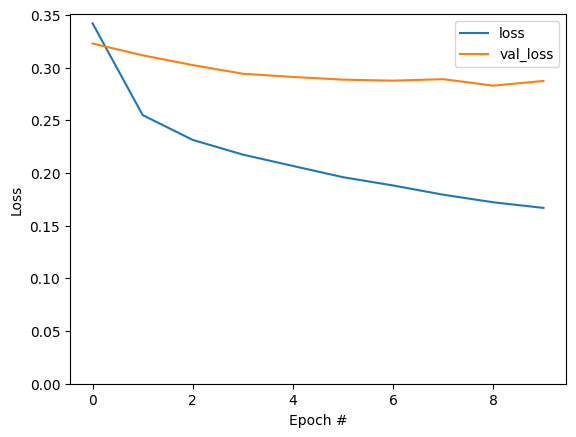

In [24]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs testing accuracy

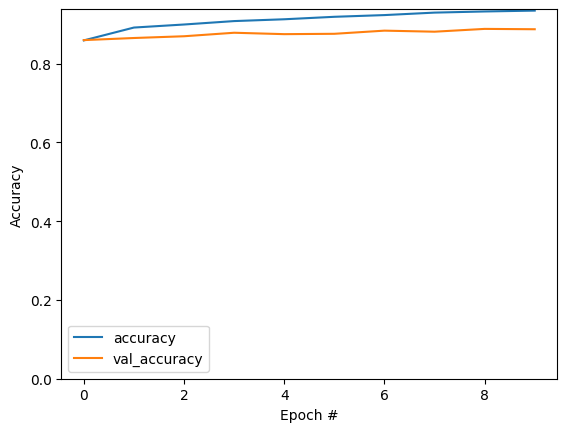

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [26]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [27]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [28]:
y_pred = text_only_model.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

36/36 [==============================] - 19s 504ms/step
Accuracy == 0.8870106761565836
F1 == [0.92812677 0.73596674]
Precision == [0.90607735 0.80821918]
Recall == [0.9512761  0.67557252]


## XLM-RoBERTa

In [29]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-12_H-768_A-12/1"
)
bert_preprocess_path = "https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_preprocess/1"

In [30]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


In [31]:
bert_preprocess_model = make_bert_preprocessing_model(["text_1"], 224)
bert_preprocess_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_1 (InputLayer)         [(None,)]                 0         
                                                                 
 tokenizer (KerasLayer)      (None, None)              0         
                                                                 
 packer (KerasLayer)         {'input_mask': (None, 22  0         
                             4),                                 
                              'input_type_ids': (None            
                             , 224),                             
                              'input_word_ids': (None            
                             , 224)}                             
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________

In [32]:
idx = np.random.choice(len(train_df_model))
row = train_df_model.iloc[idx]
sample_text_1, sample_text_2 = row["tweetText"], row["tweetText"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])


Text 1: 妇幼保健院提示您，请不要给宝宝喝爽歪歪和有添加剂的牛奶饮料，告诉家里有小孩的朋友，刚看了新闻：旺仔牛奶、可口可乐、爽歪歪。娃哈哈AD钙奶、多美滋、雅培、、美汁源果粒奶优菠萝味的。都含有肉毒杆菌。现在紧急召回，希望有儿女的爸爸妈妈相互转告。这个一定要转～～'
Text 2: 妇幼保健院提示您，请不要给宝宝喝爽歪歪和有添加剂的牛奶饮料，告诉家里有小孩的朋友，刚看了新闻：旺仔牛奶、可口可乐、爽歪歪。娃哈哈AD钙奶、多美滋、雅培、、美汁源果粒奶优菠萝味的。都含有肉毒杆菌。现在紧急召回，希望有儿女的爸爸妈妈相互转告。这个一定要转～～'
Keys           :  ['input_mask', 'input_type_ids', 'input_word_ids']
Shape Word Ids :  (1, 224)
Word Ids       :  tf.Tensor(
[     0      6  73034  42986  65309   6105  51827   3479      4   9736
   7402   4766  65953  15530  60988 138329], shape=(16,), dtype=int32)
Shape Mask     :  (1, 224)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 224)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [33]:
def dataframe_to_dataset(dataframe):
    columns = ['tweetText', 'label']
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

## Preprocessing utilities

In [34]:
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

In [35]:
def preprocess_text(text_1):
  text_1 = tf.convert_to_tensor([text_1])
  output = bert_preprocess_model([text_1])
  output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
  return output

In [36]:
def preprocess_text_and_image(sample):
  text = preprocess_text(sample["tweetText"])
  return {"text": text}

In [37]:
batch_size = 32
auto = tf.data.AUTOTUNE

In [38]:
def prepare_dataset(dataframe, training=True):
  ds = dataframe_to_dataset(dataframe)
  if training:
      ds = ds.shuffle(len(train_df_model))
  ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
  ds = ds.batch(batch_size).prefetch(auto)
  return ds

In [39]:
train_ds = prepare_dataset(train_df_model)
test_ds = prepare_dataset(test_df_model, False)

## Model Building

In [40]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(224,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

## TextOnly model

In [41]:
def create_text_only_model(
    num_projection_layers=0,
    projection_dims=128,
    dropout_rate=0.1,
    text_trainable=False,
    attention=False
):
    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(224,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    text_projections = text_encoder(text_inputs)
    text_projections = keras.layers.Dropout(dropout_rate)(text_projections)
    outputs = keras.layers.Dense(1, activation="sigmoid")(text_projections)
    return keras.Model([text_inputs], outputs)

In [42]:
text_only_model1 = create_text_only_model(num_projection_layers=1, projection_dims=128, dropout_rate=0.0)

In [43]:
epochs = 10
batch_size = 32

In [44]:
text_only_model1.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=loss, metrics=metrics
)
history1 = text_only_model1.fit(train_ds, validation_data=test_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/10
130/130 [==============================] - 99s 617ms/step - loss: 0.5335 - accuracy: 0.8134 - precision: 0.6190 - recall: 0.1845 - val_loss: 0.5545 - val_accuracy: 0.7669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
130/130 [==============================] - 78s 599ms/step - loss: 0.4894 - accuracy: 0.8080 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5493 - val_accuracy: 0.7669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
130/130 [==============================] - 78s 597ms/step - loss: 0.4859 - accuracy: 0.8080 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5362 - val_accuracy: 0.7669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
130/130 [==============================] - 81s 628ms/step - loss: 0.4853 - accuracy: 0.8080 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5432 - val_accuracy: 0.7669 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
130/130 [================

Plot training loss vs testing loss

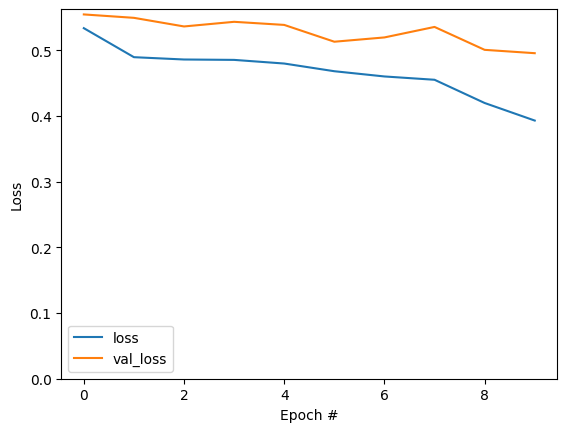

In [45]:
plt.plot(history1.history['loss'], label='loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Plot training accuracy vs testing accuracy

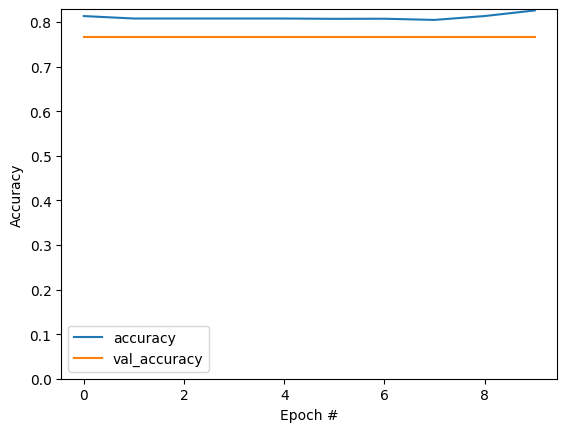

In [46]:
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend()

In [47]:
y_pred = text_only_model1.predict(test_ds)
y_pred = [1 if i>=0.5 else 0 for i in y_pred]
print(f'Accuracy == {accuracy_score(y_test,y_pred)}')
print(f'F1 == {f1_score(y_test,y_pred,average=None)}')
print(f'Precision == {precision_score(y_test,y_pred,average=None)}')
print(f'Recall == {recall_score(y_test,y_pred,average=None)}')

36/36 [==============================] - 17s 465ms/step
Accuracy == 0.7669039145907474
F1 == [0.86807654 0.        ]
Precision == [0.76690391 0.        ]
Recall == [1. 0.]
